In [ ]:
!git clone https://github.com/Yutong-Lu/Datathon-4.git

In [5]:
cd ./Datathon-4

/content/Datathon-4


In [50]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold

In [43]:
def get_dataframe(name):
    df = pd.read_csv(f'{name}.csv')
    df = df.dropna()
    return df

In [58]:
name = 'datathon4'
df = get_dataframe(name)
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
8286,80443,9930,89,1,67.0,28.146291,0,Caucasian,M,167.64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
8492,66332,22503,89,0,60.0,34.574559,0,Caucasian,M,177.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
8717,107612,82369,89,0,66.0,25.775925,1,Caucasian,M,185.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Musculoskeletal/Skin,Undefined diagnoses
8727,88203,95246,89,0,55.0,56.659238,0,Other/Unknown,F,162.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
9235,77729,21614,89,0,21.0,22.180764,0,Caucasian,M,182.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


In [64]:
df.isnull().sum().sum()

0

In [65]:
df.isna().sum().sum()

0

In [45]:
print(df.columns.tolist())

['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_

#Preparing train, validation, and test sets

Based on the descriptions of the columns, 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' both provide probabilistic predictions of mortality. Since they have a high correlation, we can combine them into a single target column for our mortality prediction neural network.

In [46]:
df['mortality_prob'] = df[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].mean(axis=1)
df = df.drop(['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], axis=1)

### encoding non-numerical data
According to the below cell, we have identified that our non-numerical columns have limited number of values, suggesting that they are categorical variables. Categorical variables are those that can be divided into distinct categories. In many machine learning algorithms, these variables need to be converted into numerical form. This process is known as encoding. Encoding categorical variables can help improve the performance of machine learning algorithms by converting non-numerical data into numerical data that can be provided to ML algorithms to generate accurate prediction

In [47]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

unique_values = df[non_numeric_columns].nunique()
print(unique_values)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']
ethnicity                4
gender                   2
hospital_admit_source    7
icu_admit_source         4
icu_stay_type            1
icu_type                 5
apache_3j_bodysystem     7
apache_2_bodysystem      6
dtype: int64


In [48]:
le = LabelEncoder()

# Apply Label Encoding to each categorical column
df_encoded = df.copy()
for column in non_numeric_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Check that the Label Encoding has worked properly

unique_values = df_encoded[non_numeric_columns].nunique()
print(unique_values)

non_numeric_columns = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

ethnicity                4
gender                   2
hospital_admit_source    7
icu_admit_source         4
icu_stay_type            1
icu_type                 5
apache_3j_bodysystem     7
apache_2_bodysystem      6
dtype: int64
[]


#Feature selection

### 1. Using Variance Threshold

Variance Threshold is a feature selection method that works by eliminating features with very low variance, i.e., features with not much useful information. This method is useful when you want to reduce the dimensionality of the dataset without losing too much information. The idea behind Variance Threshold is that when a feature doesn't vary much within itself, it generally has very little predictive power. Therefore, features with a variance below a certain threshold are considered uninformative and are removed from the dataset.

In [51]:
selector = VarianceThreshold(threshold = 0)

In [52]:
selector.fit(df_encoded)

VarianceThreshold(threshold=0)

In [55]:
mask = selector.get_support()
df_encoded_variance_threshold = df_encoded.loc[:, mask]

df_encoded_variance_threshold.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,diabetes_mellitus,immunosuppression,apache_3j_bodysystem,apache_2_bodysystem,mortality_prob
8286,80443,9930,89,1,67.0,28.146291,0,1,1,167.64,...,7.524,73.0,73.0,121.666667,121.666667,0.0,1.0,6,0,0.825
8492,66332,22503,89,0,60.0,34.574559,0,1,1,177.80,...,7.310,68.0,68.0,188.888889,188.888889,0.0,0.0,6,0,0.320
8717,107612,82369,89,0,66.0,25.775925,1,1,1,185.40,...,7.450,264.0,160.0,382.608696,382.608696,0.0,0.0,4,5,0.145
8727,88203,95246,89,0,55.0,56.659238,0,3,0,162.60,...,7.295,135.0,85.0,85.000000,85.000000,0.0,0.0,1,1,0.250
9235,77729,21614,89,0,21.0,22.180764,0,1,1,182.90,...,7.368,51.0,51.0,92.727273,92.727273,0.0,0.0,6,0,0.035


### 2. Removing multicollinearity
Multicollinearity is a situation in which two or more independent variables in a multiple regression model are highly linearly related, meaning they contain similar information about the variance within the dataset. When independent variables are correlated, it can cause problems in the interpretation of the model coefficients, as it undermines the statistical significance of the independent variables. The presence of multicollinearity can lead to an inflated standard error, which can make it difficult to accurately determine which predictors are significantly related to the response variable. It can also lead to unstable estimates of the regression coefficients, which can cause the estimated coefficients to change significantly depending on the subset of the data used. Therefore, it is often beneficial to remove multicollinearity from a dataset before training a machine learning model.

We have used a correlation matrix to identify pairs of variables that have a correlation greater than 0.9. We have then removed the variables from your dataset that are part of these pairs.

First we separate the features (X) and target (y) from the DataFrame

In [81]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('mortality_prob', axis=1)
y = df_encoded['mortality_prob']

print(X.shape, y.shape)

(25, 184) (25,)


<Axes: >

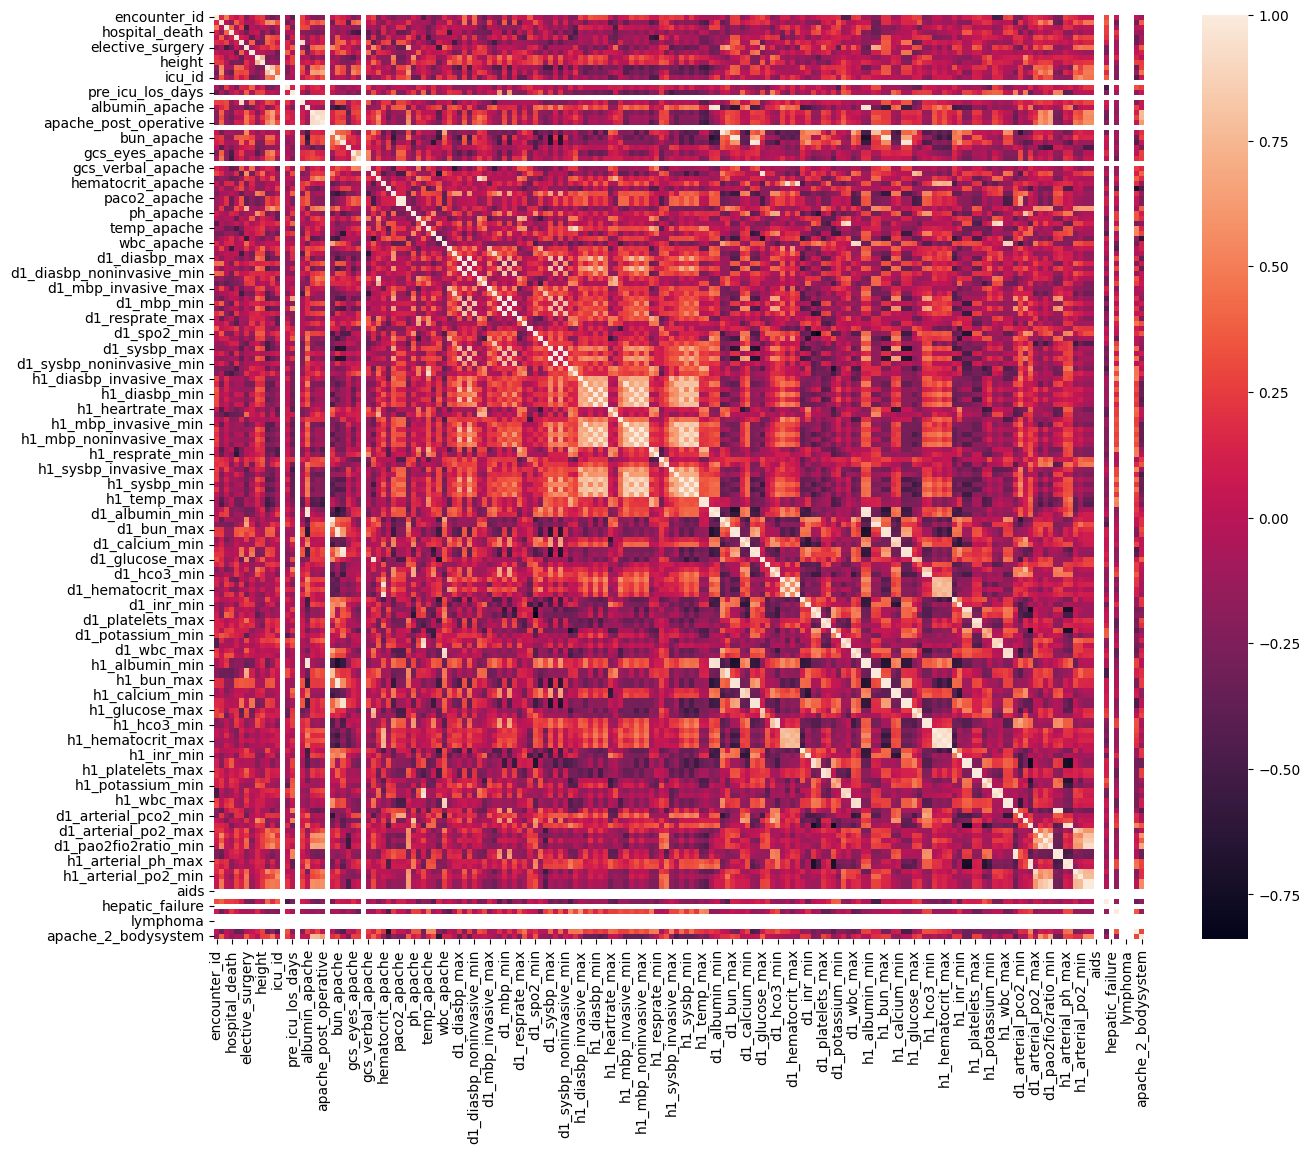

In [82]:
#Plotting the correlation heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix)

In [83]:
multicollinear_cols = set()

for i in range (len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i,j]) > 0.9:
      multicollinear_cols.add(correlation_matrix.columns[i])

print(len(multicollinear_cols))

71


In [84]:
X.drop(labels=multicollinear_cols, axis = 1, inplace=True)

In [85]:
X.shape

(25, 113)

Now split them into train and test sets.

In [ ]:
# Split the features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)